## Out Of Distribution Classifier using gpt-3.5-turbo

In [1]:
import pandas as pd
from datasets import  load_dataset
import openai
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from util_functions import compute_metrics, print_eval_metrics, save_metrics
import os
tqdm.pandas()

openai.api_key = os.environ.get('OPENAI_API_KEY')  # Enter your Openai api key

In [2]:
def ood_classifier_gpt35(text: str) -> str:
    """
    Classifies whether a given text is a movie review or not,
    using Openai's gpt-3.5-turbo model.

    Args:
    text: str
        A text string
    response_text: str
        The prediction
    """
    messages = [
        {"role": "user",
         "content": f""" Assess if the following is a movie review or not and return exactly one word: 
         'yes' if it is a review for movies or any kind of tv show review or film review or cinema review,
         'no' if it is not 
         {text} """}
        ]
    
    response = openai.ChatCompletion.create(
                      model="gpt-3.5-turbo",
                      messages=messages,
                      max_tokens=3,
                      n=1,
                      stop=None,
                      temperature=0.1,
                      request_timeout=4)

    response_text = response.choices[0].message.content.strip().lower()

    return response_text

#### Load Review Datasets

In [3]:
imdb = load_dataset("imdb")
amazon = load_dataset("amazon_polarity", split='test')[:10_000]
yelp = load_dataset("yelp_polarity", split='train')[:10_000]


#### Preprocess Datasets 

In [4]:
df_imdb = pd.concat([pd.DataFrame(imdb['train']),  pd.DataFrame(imdb['train'])], axis=0, ignore_index=True)[:10_000]
df_imdb.loc[:, 'label'] = 1

In [5]:
df_amazon = pd.DataFrame(amazon)
df_amazon['text'] = df_amazon['title'] + '. ' + df_amazon['content']
df_amazon = df_amazon.drop(['title', 'content'], axis=1)
df_amazon.loc[:, 'label'] = 0

In [6]:
df_yelp = pd.DataFrame(yelp)
df_yelp.loc[:, 'label'] = 0

In [7]:
# Sample 600 total examples: 300 imdb, 150 amazon, 150 yelp
df_imdb = df_imdb.sample(n=300, random_state=42).reset_index(drop=True)
df_amazon = df_amazon.sample(n=150, random_state=42).reset_index(drop=True)
df_yelp = df_yelp.sample(n=150, random_state=42).reset_index(drop=True)

#### Combine Datasets

In [8]:
test_df = pd.concat([df_imdb, df_amazon, df_yelp], axis=0, ignore_index=True)

In [9]:
test_df.loc[:, 'pred'] = None
test_df

,text,label,pred
0,"Hooper is Not Funny, Not Fasted paced, Not rom...",1,None
1,This movie is a waste of film stock. Do you be...,1,None
2,...and it is this film. I imagine that if inde...,1,None
3,"I really liked ZB1. Really, I did. I have no p...",1,None
4,SPOILER WARNING: There are some minor spoilers...,1,None
...,...,...,...
595,"i found out that portion size is good, then ba...",0,None
596,"So yeah, pretty much what everyone has said so...",0,None
597,"So, this is what happened.\n\nI went their com...",0,None
598,Last night was my first time at D's. The beer ...,0,None


In [ ]:
max_retries = 12
for index, row in tqdm(test_df.iterrows(), total=len(test_df), colour='green'):
    if pd.isnull(row['pred']):
        retries = 0
        while retries < max_retries:
            try:
                test_df.loc[index, 'pred'] = ood_classifier_gpt35(row['text'])
                test_df.to_csv('checkpoints.csv', index=False)
                break
            except Exception as e:
                retries += 1
                print(f"Error processing row {index}, retry {retries}/{max_retries}: {e}")
                if retries == max_retries:
                    print(f"Maximum retries reached for row {index}. Skipping.")
                    break  


#### Transform predictions column and store results in .csv file

In [13]:
test_df.loc[test_df['pred'] == 'no', 'pred'] = 0
test_df.loc[test_df['pred'] == 'yes', 'pred'] = 1
test_df['pred'] = test_df['pred'].astype(np.int64)
test_df.to_csv('predictions_ood.csv', index=True)
print("Stored results.")


Stored results.


In [14]:
test_df

,text,label,pred
0,"Hooper is Not Funny, Not Fasted paced, Not rom...",1,1
1,This movie is a waste of film stock. Do you be...,1,1
2,...and it is this film. I imagine that if inde...,1,1
3,"I really liked ZB1. Really, I did. I have no p...",1,1
4,SPOILER WARNING: There are some minor spoilers...,1,1
...,...,...,...
595,"i found out that portion size is good, then ba...",0,0
596,"So yeah, pretty much what everyone has said so...",0,0
597,"So, this is what happened.\n\nI went their com...",0,0
598,Last night was my first time at D's. The beer ...,0,0


#### Compute metrics

In [15]:
metrics = compute_metrics(true_labels=test_df['label'].to_list(), 
                          predicted_labels=test_df['pred'].to_list())
print_eval_metrics(metrics)
save_metrics(metrics=metrics, file_name="metrics_ood")

The precision score is:  0.89
The recall score is:  0.94
The f1_score score is:  0.91
The accuracy score is:  0.91
Saved metrics_ood.json!


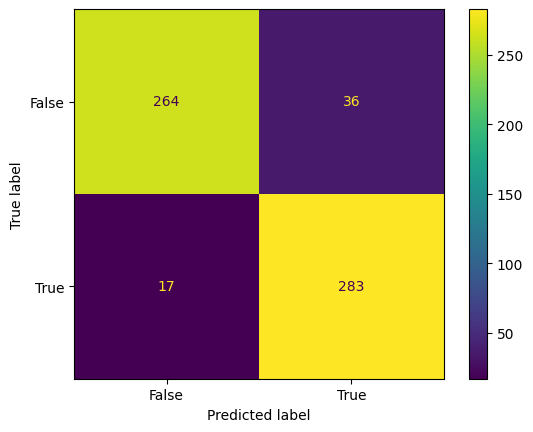

In [16]:
conf_matrix = confusion_matrix(y_true=test_df['label'].values, 
                               y_pred=test_df['pred'].values)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                                    display_labels=[False, True])
cm_display.plot()
plt.show()

In [17]:
errors_df = test_df[test_df['label'] != test_df['pred']]
errors_df.to_csv('errors_ood.csv')